  # Autoencoder - Baseline mode - Copy 2

# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
import shutil
import getpass
import yaml

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

WANDB_ACTIVE = False

os.environ["WANDB_NOTEBOOK_NAME"] = "Autoencoder_dev.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import wandb
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace 

timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print('Timestamp: ',timestamp)

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118
Timestamp:  2024_06_12_09:46:33


In [3]:
# Soft Nearest Neighbor Loss
# Copyright (C) 2020  Abien Fred Agarap
__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"
"""Sample module for using DNN classifier with SNNL"""

from snnl.utils import parse_args, get_hyperparameters, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary, define_autoencoder_model
from snnl.utils import save_checkpoint_v2, load_checkpoint_v2

from snnl.models import Model
from snnl.models import DNN 
from snnl.models import Autoencoder
from snnl.losses import SNNLoss

'Sample module for using DNN classifier with SNNL'

In [4]:
current_device = get_device()
# print(f"Current device is : {current_device}")

current_device = set_device(0)

 device: 0   Quadro GV100                   :  free: 25,523,978,240 B   (23.77 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 33,140,834,304 B   (30.86 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 2   NVIDIA TITAN Xp                :  free: 10,975,051,776 B   (10.22 GB)    total: 12,774,539,264 B   (11.90 GB)
 Current CUDA Device is: cuda:0 Quadro GV100 0
 Running on: Quadro GV100 0
 Switch to cuda:0 
 Running on: Quadro GV100 0


### main(args)

In [5]:
# if __name__ == "__main__":
input_args = f" --seed               1234 " \
             f" --runmode            baseline" \
             f" --configuration      hyperparameters/autoencoder_cellpainting-150.yaml"
             # f" --runmode            snnl" \
             # f" --configuration    hyperparameters/dnn_mnist.json"
args = parse_args(input_args.split())
args

with open(args.configuration) as f:
    args = types.SimpleNamespace(**yaml.safe_load(f), **(vars(args)))
args.batch_size = args.cellpainting_args['batch_size']
args.compounds_per_batch = args.cellpainting_args['compounds_per_batch']
set_global_seed(args.seed)


Namespace(seed=1234, runmode='baseline', configuration='hyperparameters/autoencoder_cellpainting-150.yaml')

## Define dataset and dataloaders

In [6]:
trn_file_sz = args.cellpainting_args['train_end'] - args.cellpainting_args['train_start']
val_file_sz = args.cellpainting_args['val_end'] - args.cellpainting_args['val_start']
smp_sz = args.cellpainting_args['sample_size']
buf_sz = args.cellpainting_args['compounds_per_batch']
bth_sz = args.cellpainting_args['batch_size']
recs_per_batch = smp_sz * bth_sz * buf_sz

for file_sz in [trn_file_sz, val_file_sz]:
    bth_per_epoch = file_sz // recs_per_batch
    print(f" - Each mini-batch contains {recs_per_batch/smp_sz} compounds with {smp_sz} samples per each compound : total {recs_per_batch} rows")
    print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
    print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
    print(f" - Last partial batch contains : {file_sz % recs_per_batch} rows")
    print() 

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 800
 - Rows covered by 800 full size batches (300 rows) per epoch:  240000
 - Last partial batch contains : 0 rows

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 80
 - Rows covered by 80 full size batches (300 rows) per epoch:  24000
 - Last partial batch contains : 0 rows



In [7]:
#### Load CellPainting Dataset
if args.dataset == 'cellpainting':
    print(f" load {args.dataset}")
    train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
    train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
    val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
    val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

# for idx, batch in enumerate(train_loader):
#     print(f"{idx:4d}, {batch[0].shape}, {batch[1].shape},{batch[2].shape},{batch[3].shape},{batch[4].shape}, {batch[3][:3]}, {batch[3][-3:]}")
#     display_cellpainting_batch(idx, batch)
#     if idx >= 0:
#         break

 load cellpainting
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    _init()_    -- type :             train
    _init()_    -- start :            0
    _init()_    -- end :              240000
    _init()_    -- numrows :          240000
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    _init()_    -- type :             val
    _init()_    -- start :            0
    _init()_    -- end :              24000
    _init()_    -- numrows :          24000


In [8]:
# args.project_name = 'CellPainting_Profiles'
# args.exp_title = 'snglOpt-150Ltnt_512'
# args.exp_desc = 'Autoencoder Training in Baseline mode - SnglOpt, 150 dim latent, 512 Midlayer'

args.exp_id   = None
args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
args.exp_date = datetime.now().strftime('%Y%m%d')

## --- for restarts
# args.exp_id   = '0g8w13h6'
# args.exp_name = 'AE_0516_1104'
# args.exp_date = '20240516'
##-----------------
print(f" Experiment name {args.exp_name} - description: {args.exp_desc}")

 Experiment name AE_0612_0947 - description: Autoencoder Training in Baseline mode - Single Optimizer, 150 dim latent layer - snglOpt-150Ltnt


In [9]:
if WANDB_ACTIVE:
    wandb_run = init_wandb(args)

    args.exp_id = wandb_run.id
    print(f" run id is : {args.exp_id}")

# Define autoencoder model

## Override arguments

In [10]:
args.show_every = 1
args.save_every = 25
args.temperature   = 0.0
args.loss_factor   = 1.0        ## 2.0e+00
args.snnl_factor   = 0.0       ## 1.0e+00
args.learning_rate = 1.0e-03    ## 0.001
args.temperatureLR = 0.0e-04    ## 1e-4
print(f"   Latent dim        {args.code_units}")
print(f"   loss_factor       {args.loss_factor}")
print(f"   snnl_factor       {args.snnl_factor}")
print(f"   temperature       {args.temperature}")
print(f"   learning_rate     {args.learning_rate}")
print(f"   temperatureLR:    {args.temperatureLR}")
type(args.learning_rate)

   Latent dim        150
   loss_factor       1.0
   snnl_factor       0.0
   temperature       0.0
   learning_rate     0.001
   temperatureLR:    0.0


float

In [11]:
list_namespace(args)


command line parms : 
-----------------------
SGD_weight_decay.........  0
activations..............  ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
adam_weight_decay........  0
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  100
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_start...............

## Define Model

In [12]:
model = define_autoencoder_model(args, embedding_layer = 4, device = current_device)
model.device

Defining model in baseline mode
    Model_init()_    -- AE - support for unsupervised in autoencoding mode is True
    layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
    layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    2  type:linear           input:   1024  output:    128    weights: [128, 1024]   
    layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    4  type:linear           input:    128  output:    150    weights: [150, 128]   
    layer pair:    5  type:linear           input:    150  output:    128    weights: [128, 150]   
    layer pair:    6  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    7  type:linear           input:    128  output:   1024    weights: [1024, 128]   
    layer pair:    8  type:relu             input:      0  output:      0    weights: [0, 0] 

/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


'cuda:0'

In [13]:
# if args.runmode.lower() == "baseline":
#         mode = "autoencoding",
#         criterion   = torch.nn.MSELoss(reduction='mean'),
#         adam_weight_decay = 0,
#         use_scheduler = True,
#         use_snnl = False,
#         snnl_factor= 0.0,
#         use_temp_scheduler = False

# elif args.runmode.lower() == "snnl":
#         mode="latent_code",
#         criterion = torch.nn.MSELoss(reduction='mean'),
#         adam_weight_decay = 0,
#         use_scheduler = True,
#         use_snnl=True,
#         snnl_factor=args.snnl_factor,
#         temperature=args.temperature,
#         temperatureLR=args.temperatureLR,
#         use_annealing= False,        
#         use_sum = False,
#         SGD_weight_decay= 0,
#         use_temp_scheduler = False


In [14]:
if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = True)

# Autoencoder `fit(data_loader = train_loader, epochs = epochs)` 

In [15]:
# epoch = -1
# filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
# print(filename)
# save_checkpoint_v2(epoch, model, filename) 

In [34]:
# starting_epoch, epochs = 0, 25
# starting_epoch, epochs

print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 301 to 400 


In [35]:
# snnl_factor = 10.0
# print(f" loss_factor         : {model.loss_factor}")
# print(f" snnl_factor         : {model.snnl_factor}")
# print(f" model.monitor_grads_layer: {model.monitor_grads_layer}")
# print(f" model.temperature : {model.temperature}")
# print(f" Learning rate     : {model.optimizer.param_groups[0]['lr']}") 
# print(f" Temperature LR    : {model.temperatureLR}") 
# model.temperature = 40.0
# model.snnl_factor = 0.5
# model.loss_factor = 0.1
# model.temperatureLR = 1e-4
# model.optimizer.param_groups[0]['lr'] = 0.001
# model.temp_optimizer.param_groups[0]['lr'] = 0.000005
# model.monitor_grads_layer = -2
print()
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
# print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" Learning rate       : {args.learning_rate}") 
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" Use Scheduler       : {model.use_scheduler}") 
print()
print(f" Use snnl            : {model.use_snnl}") 
print(f" snnl_factor         : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature         : {model.temperature.item()}")
    print(f" Temperature LR      : {model.optimizer.param_groups[1]['lr']}") 
    # print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 
    print(f" Use Temp Scheduler  : {model.use_temp_scheduler}") 
    print(f" Temp Scheduler      : {model.temp_scheduler}") 
print(f" run epochs {starting_epoch+1} to {epochs} ")
# wandb.config.update(args)


 loss_factor         : 1.0
 monitor_grads_layer : None
 Learning rate       : 0.001
 Learning rate       : 0.0005
 Use Scheduler       : True

 Use snnl            : False
 snnl_factor         : 0.0
 run epochs 301 to 400 


In [ ]:
print(f"{datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {starting_epoch+1:4d} of {epochs:4d}")
header = True

for epoch in range(starting_epoch,epochs):
    train_loss = model.epoch_train(train_loader, epoch)
    val_loss = model.epoch_validate(val_loader, epoch)
    
    display_epoch_metrics(model, epoch, epochs, header)
    header = False
    model.scheduling_step(val_loss)
    
    if WANDB_ACTIVE:
        epoch_metrics = {x:y[-1] for x,y in model.training_history['val'].items()} | \
                        {x:y[-1] for x,y in model.training_history['trn'].items()} 
        wandb_log_metrics( data = epoch_metrics, step = epoch)
    
    if (epoch + 1) % args.save_every == 0:
        filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
        save_checkpoint_v2(epochs, model, filename, update_latest=False, update_best=False)    

20240612_095228  epoch  301 of  400
                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |   R2                     |   Vld_loss    PrimLoss      SNNL   |   R2                     |    LR       temp LR   |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|-----------------------|
09:54:32 ep 301 /400 |   0.239583    0.239583    0.000000 |   0.000000    0.0000e+00 |   0.6079                 |   0.279919    0.279919    0.000000 |   0.5404                 |   0.000500   0.000000 |
09:56:35 ep 302 /400 |   0.239790    0.239790    0.000000 |   0.000000    0.0000e+00 |   0.6127                 |   0.279446    0.279446    0.000000 |   0.5431                 |   0.000500   0.000000 |
09:58:39 ep 303 /400 |   0.239667    0.239667    0.000000 |   0.000000    0.0000e+00 |   0.6174                 |   0.280098    0.280098    0.000000 |   0.5

In [41]:
starting_epoch, epochs 

(300, 400)

In [25]:
# starting_epoch = 350
# epochs = 35
starting_epoch = epochs
epochs += 200
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 101 to 300 


In [38]:
for epoch in range(epochs):
    display_epoch_metrics(model, epoch)

                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |   R2                     |   Vld_loss    PrimLoss      SNNL   |   R2                     |    LR       temp LR   |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|-----------------------|
11:31:37 ep   1 /400 |   0.568568    0.568568    0.000000 |   0.000000    0.0000e+00 |  -0.4173                 |   0.487766    0.487766    0.000000 |   0.2318                 |   0.001000   0.000000 |
11:33:45 ep   2 /400 |   0.465842    0.465842    0.000000 |   0.000000    0.0000e+00 |   0.2506                 |   0.440903    0.440903    0.000000 |   0.3068                 |   0.001000   0.000000 |
11:35:48 ep   3 /400 |   0.419257    0.419257    0.000000 |   0.000000    0.0000e+00 |   0.3841                 |   0.400125    0.400125    0.000000 |   0.4105                 |   0.001000   0

In [ ]:
if WANDB_ACTIVE:
    wandb_run.finish()
    WANDB_ACTIVE = False

# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

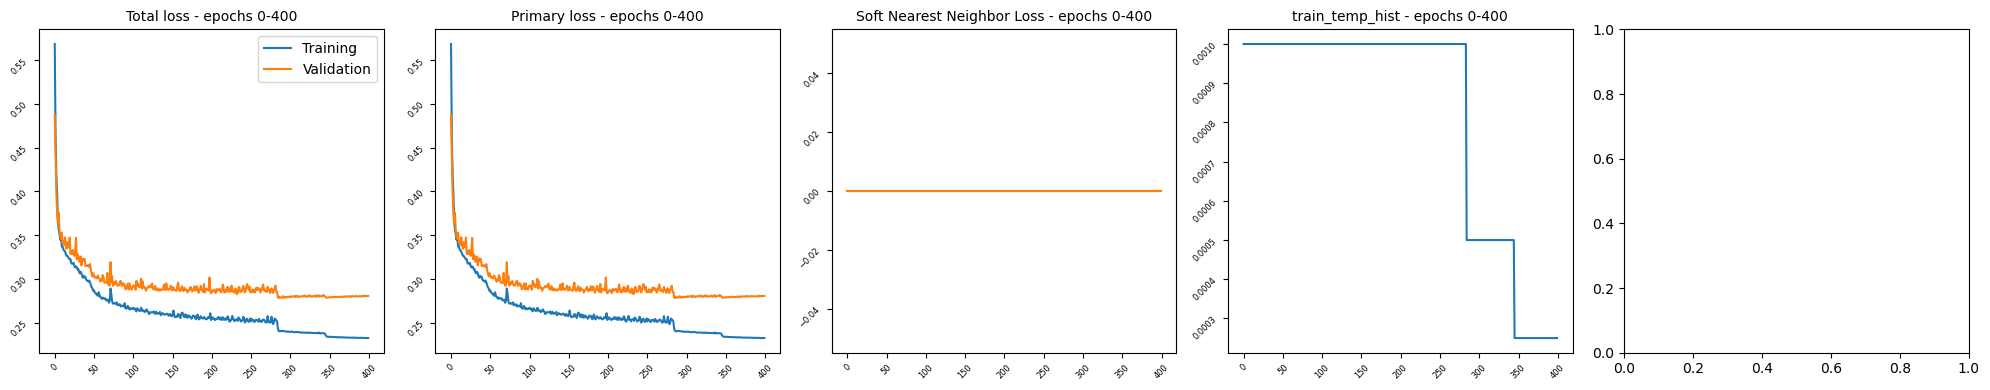

In [42]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

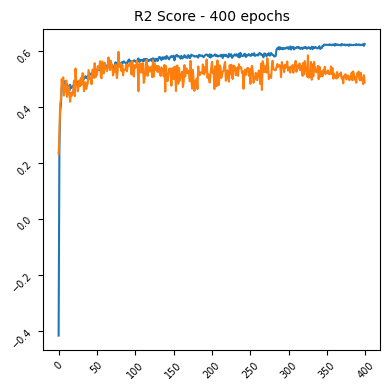

In [39]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Save model results and model

In [ ]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
title="autoencoder"
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

In [ ]:
# save_model(model, filename)
# export_results(model=model, filename=filename)
# save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

In [ ]:
model.name
args.runmode
ex_timestamp
ex_title
epoch
args.compounds_per_batch
model.snnl_factor

In [ ]:
filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
print(filename)

In [ ]:
filename = f"{model.name}_{args.model.lower()}_{ex_timestamp}_{ex_title}_{epoch+1:03d}_cpb_{args.compounds_per_batch}_copy"
print(filename)
    # export_results(model=model, filename=filename)
save_checkpoint_2(epochs, model, filename, update_latest=False, update_best=False)  

# Load model

In [17]:
ex_epochs = 200
# ex_mode = 'snnl'
ex_runmode = 'baseline'
ex_date = "20240605"
ex_title="snglOpt-150Ltnt"
# ex_title="secondTry"
# ex_title="dropout04"
# title="autoencoder"
# title='Xentropy'

In [18]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{ex_epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_ep_*.pt"
print(file_pattern)

AE_baseline_20240605_snglOpt-150Ltnt_200.pt
AE_baseline_20240605_snglOpt-150Ltnt_ep_*.pt


In [19]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist

['AE_baseline_20240605_snglOpt-150Ltnt_ep_025.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_050.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_075.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_100.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_125.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_150.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_175.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_200.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_225.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_250.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_275.pt',
 'AE_baseline_20240605_snglOpt-150Ltnt_ep_300.pt']

[25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

In [23]:
ex_epoch = 300

In [24]:
filename = f"{model.name}_{args.runmode}_{ex_date}_{ex_title}_ep_{ex_epoch:03d}"   
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

AE_baseline_20240605_snglOpt-150Ltnt_ep_300.pt

 *** Checkpoint EXISTS *** 



In [25]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

--> AE_baseline_20240605_snglOpt-150Ltnt_ep_300.pt
epoch                                   , <class 'int'>                                                 -- model attr set
state_dict                              , <class 'collections.OrderedDict'>                             -- model attr set
optimizer                               , <class 'torch.optim.adam.Adam'>                               -- model attr set
temp_optimizer                          , <class 'NoneType'>                                            -- model attr set
optimizer_state_dict                    , <class 'dict'>                                                -- model attr set
temp_optimizer_state_dict               , <class 'NoneType'>                                            -- model attr set
scheduler                               , <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>          -- model attr set
temp_scheduler                          , <class 'NoneType'>                                   

In [27]:
print(current_device)
print(model.device)
# model.device = current_device
# print(model.device)

cuda:0
cuda:0


In [28]:
model.train()
model = model.cuda(device=current_device)
print(model.device)

Autoencoder(
  (primary_criterion): MSELoss()
  (layers): ModuleList(
    (0): Linear(in_features=1471, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=150, bias=True)
    (5): Linear(in_features=150, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=1471, bias=True)
  )
)

cuda:0


In [29]:
print(f" last epoch  {last_epoch}")

 last epoch  300


In [30]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 301 to 400 


In [32]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()



 model device         : cuda:0
 model temperature    : 0

 loss_factor          : 1.0
 monitor_grads_layer  : None
 Learning rate        : 0.0005
 snnl_factor          : 0.0

 trn_time             : 22:29:49  
 trn_ttl_loss         : 0.239348 
 trn_prim_loss        : 0.239348 
 trn_snn_loss         : 0.000000 
 trn_R2_score         : 0.614851 
 trn_lr               : 0.000500 

 val_time             : 22:30:00  
 val_ttl_loss         : 0.279226 
 val_prim_loss        : 0.279226 
 val_snn_loss         : 0.000000 
 val_R2_score         : 0.530867 



In [ ]:
model.optimizer.__dict__
print()

In [ ]:
model.scheduler.__dict__

# Misc code

In [ ]:
# loaded_data = import_results(filename)

# for k in loaded_data.keys():
#     print(k, type(loaded_data[k]), len(loaded_data[k]))
# print("\nTraining History")
# results = loaded_data['training_history']
# for k,v in results.items():
#     print(' ',k , len(v))
#     for kk,vv in results[k].items():
#         print( f"   {kk:20s} {len(vv)}")
# print("\nModel Parameters")
# model_parameters = loaded_data['params']
# for k,v in model_parameters.items():
#     print(f"   {k:25s} {v}" )
 

In [ ]:
# model_attributes = model.__dict__
# from collections import defaultdict
# output = defaultdict(dict)

# for key, value in model_attributes.items():
#         if key[0] == "_" or type(value) in [torch.device, torch.optim.Adam , torch.optim.SGD]:
#             continue
#         if key == 'training_history':
#             output[key] = value
#         else:
#             output['params'][key] = value
#             print(f" {key:30s}    {type(value)}   ")

# output.keys()
# output['params']
# output['training_history'].keys()

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )
#     model.__dict__[k] = results[k]

In [37]:
# for key in ['trn', 'val']:
#     del_keys = []
#     for k,v in model.training_history[key].items():
#         print(k, len(v))
#         if len(v) == 0 :
#             del_keys.append(k)
#     del_keys
#     for k in del_keys:    
#         del  model.training_history[key][k]
#     print('-----------------------')

# model.training_history['val'].keys()
# np.argmin(model.training_history['trn']['trn_ttl_loss']), np.min(model.training_history['trn']['trn_ttl_loss'] )
# np.argmin(model.training_history['trn']['trn_prim_loss']),np.min(model.training_history['trn']['trn_prim_loss']), np.min(model.training_history['trn']['trn_prim_loss'])  / model.loss_factor
# np.argmin(model.training_history['trn']['trn_snn_loss']), np.min(model.training_history['trn']['trn_snn_loss'] ),  np.min(model.training_history['trn']['trn_snn_loss'] ) / model.snnl_factor
# print()
# np.argmin(model.training_history['val']['val_ttl_loss']) , np.min(model.training_history['val']['val_ttl_loss'] )
# np.argmin(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']) / model.loss_factor
# np.argmin(model.training_history['val']['val_snn_loss']) , np.min(model.training_history['val']['val_snn_loss'] ), np.min(model.training_history['val']['val_snn_loss'] ) / model.snnl_factor

# model.optimizer
# model.optimizer.state_dict()
# model.optimizer.param_groups[0]['lr'], model.optimizer.param_groups[1]['lr']
# model.scheduler.__dict__

# model.optimizer = torch.optim.Adam(params = network_params, lr=0.001, weight_decay = 0.1)
# # if self.use_snnl:
# #     self.optimizer.add_param_group({'params': temp_params, 'lr': temperatureLR, 'weight_decay': adam_weight_decay})

# if model.use_scheduler:
#     model.scheduler = model._ReduceLROnPlateau(model.optimizer, mode='min', factor=0.5, patience=40, threshold=0.000001, 
#                                              threshold_mode='rel', cooldown=10, min_lr=0, eps=1e-08, verbose =True) 